In [11]:
# -------------------------------------------------------------
# Step 1: Import necessary libraries
# -------------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import mlflow
import mlflow.sklearn
import yaml
import os
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

mlflow_tracking_uri = 'http://localhost:5555'  # Optional: e.g., 'http://localhost:5555'

sns.set(style="whitegrid")
print("✅ Libraries imported.")

✅ Libraries imported.


In [12]:
# Load your datasets
df_train = pd.read_csv("../data/Training.csv")
df_test = pd.read_csv("../data/Testing.csv")

# Remove any unnamed columns
df_train = df_train.loc[:, ~df_train.columns.str.contains('^Unnamed')]
df_test = df_test.loc[:, ~df_test.columns.str.contains('^Unnamed')]

print(f"Training shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

# Prepare features and target
X_train = df_train.drop('prognosis', axis=1)
y_train = df_train['prognosis']
X_test = df_test.drop('prognosis', axis=1)
y_test = df_test['prognosis']

# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

Training shape: (4187, 133)
Test shape: (775, 133)
Number of classes: 41
Classes: ['(vertigo) Paroymsal  Positional Vertigo' 'AIDS' 'Acne'
 'Alcoholic hepatitis' 'Allergy' 'Arthritis' 'Bronchial Asthma'
 'Cervical spondylosis' 'Chicken pox' 'Chronic cholestasis' 'Common Cold'
 'Dengue' 'Diabetes ' 'Dimorphic hemmorhoids(piles)' 'Drug Reaction'
 'Fungal infection' 'GERD' 'Gastroenteritis' 'Heart attack' 'Hepatitis B'
 'Hepatitis C' 'Hepatitis D' 'Hepatitis E' 'Hypertension '
 'Hyperthyroidism' 'Hypoglycemia' 'Hypothyroidism' 'Impetigo' 'Jaundice'
 'Malaria' 'Migraine' 'Osteoarthristis' 'Paralysis (brain hemorrhage)'
 'Peptic ulcer diseae' 'Pneumonia' 'Psoriasis' 'Tuberculosis' 'Typhoid'
 'Urinary tract infection' 'Varicose veins' 'hepatitis A']


In [13]:
print("Starting training...")
# train - CHANGED TO CLASSIFIER
gbm = lgb.LGBMClassifier(
    num_leaves=31, 
    learning_rate=0.05, 
    n_estimators=100,  # Increased for classification
    objective='multiclass',
    num_class=len(label_encoder.classes_),
    random_state=42
)

gbm.fit(
    X_train, 
    y_train_encoded, 
    eval_set=[(X_test, y_test_encoded)], 
    eval_metric="multi_logloss",  # CHANGED METRIC
    callbacks=[lgb.early_stopping(10)]  # Increased patience
)

print("Starting predicting...")
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"The Accuracy of prediction is: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# feature importances
print(f"Number of features: {len(gbm.feature_importances_)}")
print(f"Top 10 feature importances: {list(gbm.feature_importances_[:10])}")

Starting training...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 4187, number of used features: 132
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -3.594808
[LightGBM] [Info] Start training from score -3.648392
[LightGBM] [Info] Start training from score -4.602070
[LightGBM] [Info] Start training from score -3.594808
[LightGBM] [Info] Start training from score -3.648392
[LightGBM] [Info] Start training from score -3.594808
[LightGBM] [Info] Start training from score -4.468539
[LightGBM] [Info] Start training from score -3.594808
[LightGBM] [Info] Start training fr

/home/junaidkhandsi/miniconda3/envs/ddsas_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/junaidkhandsi/miniconda3/envs/ddsas_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/junaidkhandsi/miniconda3/envs/ddsas_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [14]:
# Clean feature names first
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

print("Starting training with improved settings...")
gbm = lgb.LGBMClassifier(
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=200,  # Increased
    objective='multiclass',
    num_class=len(label_encoder.classes_),
    random_state=42,
    class_weight='balanced',  # Handle imbalance
    boosting_type='gbdt',
    metric='multi_logloss'
)

gbm.fit(
    X_train, 
    y_train_encoded,
    eval_set=[(X_test, y_test_encoded)],
    eval_metric="multi_logloss",
    callbacks=[
        lgb.early_stopping(20),  # More patience
        lgb.log_evaluation(50)   # Less verbose
    ]
)

# Suppress the precision warnings
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import UndefinedMetricWarning

@ignore_warnings(category=UndefinedMetricWarning)
def safe_classification_report(y_true, y_pred):
    return classification_report(y_true, y_pred, target_names=label_encoder.classes_)

print("Classification Report:")
print(safe_classification_report(y_test_encoded, y_pred))

Starting training with improved settings...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 4187, number of used features: 132
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM]

In [15]:
# Optional MLflow setup
if mlflow_tracking_uri:
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    mlflow.set_experiment("Diesease Prediction Experiment")

2025/11/08 13:18:10 INFO mlflow.tracking.fluent: Experiment with name 'Diesease Prediction Experiment' does not exist. Creating a new experiment.


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define CLASSIFICATION models
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, class_weight='balanced')  # Your current model
}

# Define hyperparameter grids for CLASSIFICATION
model_grids = {
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0],           # Regularization strength
        'penalty': ['l2']                 # Type of regularization
    },
    
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'class_weight': ['balanced', None]
    },
    
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 5]
    },
    
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 6, 10],
        'subsample': [0.8, 1.0]
    },
    
    'LightGBM': {
        'num_leaves': [31, 63],
        'learning_rate': [0.1, 0.05],
        'n_estimators': [100, 200],
        'min_data_in_leaf': [20, 50]
    }
}

In [21]:
def evaluate_model_with_gridsearch_classification(name, model, param_grid, X_train, y_train, X_test, y_test):
    """
    Evaluate a model with grid search for CLASSIFICATION problems
    """
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    # Fix for LogisticRegression convergence
    if name == 'LogisticRegression':
        model.max_iter = 5000  # Increase iterations
        # Scale data for Logistic Regression
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_to_use, X_test_to_use = X_train_scaled, X_test_scaled
    else:
        X_train_to_use, X_test_to_use = X_train, X_test
    
    print(f"🔧 Tuning {name} with grid search...")
    
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='accuracy',  # Use accuracy for classification
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_to_use, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Make predictions
    y_pred = best_model.predict(X_test_to_use)
    
    # Calculate CLASSIFICATION metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"✅ {name} Best CV Score: {grid_search.best_score_:.4f}")
    print(f"   Best Parameters: {best_params}")
    print(f"   Test Accuracy: {accuracy:.4f}")
    
    return {
        'model': best_model,
        'params': best_params,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'best_cv_score': grid_search.best_score_
    }

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
import time
import pandas as pd

print("🎯 Testing LightGBM & Random Forest (Simple Config)...")

results = {}

# Test 1: LightGBM (Simple)
print("\n💡 Testing LightGBM...")
lgb_start = time.time()

lgb_simple = lgb.LGBMClassifier(
    n_estimators=50,           # Reduced for speed
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)

lgb_simple.fit(X_train, y_train_encoded)
y_pred_lgb = lgb_simple.predict(X_test)
lgb_accuracy = accuracy_score(y_test_encoded, y_pred_lgb)
lgb_time = time.time() - lgb_start

results['LightGBM'] = {
    'accuracy': lgb_accuracy,
    'time': lgb_time
}

print(f"✅ LightGBM - Accuracy: {lgb_accuracy:.4f}, Time: {lgb_time:.2f}s")

# Test 2: Random Forest (Simple)
print("\n🌲 Testing Random Forest...")
rf_start = time.time()

rf_simple = RandomForestClassifier(
    n_estimators=50,           # Reduced for speed
    max_depth=10,              # Limited depth
    random_state=42,
    n_jobs=-1
)

rf_simple.fit(X_train, y_train_encoded)
y_pred_rf = rf_simple.predict(X_test)
rf_accuracy = accuracy_score(y_test_encoded, y_pred_rf)
rf_time = time.time() - rf_start

results['RandomForest'] = {
    'accuracy': rf_accuracy, 
    'time': rf_time
}

print(f"✅ Random Forest - Accuracy: {rf_accuracy:.4f}, Time: {rf_time:.2f}s")

# Display Comparison
print("\n📊 QUICK COMPARISON:")
print("=" * 40)
comparison_df = pd.DataFrame([
    {
        'Model': 'LightGBM',
        'Accuracy': results['LightGBM']['accuracy'],
        'Training Time (s)': results['LightGBM']['time']
    },
    {
        'Model': 'RandomForest', 
        'Accuracy': results['RandomForest']['accuracy'],
        'Training Time (s)': results['RandomForest']['time']
    }
]).sort_values('Accuracy', ascending=False)

display(comparison_df)

# Winner
best_model = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']
print(f"\n🏆 QUICK WINNER: {best_model} with {best_accuracy:.4f} accuracy!")

🎯 Testing LightGBM & Random Forest (Simple Config)...

💡 Testing LightGBM...
✅ LightGBM - Accuracy: 0.9148, Time: 1.82s

🌲 Testing Random Forest...
✅ Random Forest - Accuracy: 0.5058, Time: 0.23s

📊 QUICK COMPARISON:


,Model,Accuracy,Training Time (s)
0,LightGBM,0.914839,1.820033
1,RandomForest,0.505806,0.234195



🏆 QUICK WINNER: LightGBM with 0.9148 accuracy!


In [50]:
import dagshub
import requests
import mlflow
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb


print("🔧 Initializing DagsHub MLflow...")

# Exact code from DagsHub docs
dagshub.init(repo_owner='jkhan2211', repo_name='DiseaseFeatureClassifiers', mlflow=True)

print("✅ DagsHub initialized!")
print(f"📊 Tracking URI: {mlflow.get_tracking_uri()}")

# Simple test from docs
print("\n🧪 Running simple test from DagsHub docs...")
mlflow.autolog()

print("Completed")


🔧 Initializing DagsHub MLflow...


INFO:httpx:HTTP Request: GET https://dagshub.com/api/v1/repos/jkhan2211/DiseaseFeatureClassifiers "HTTP/1.1 200 OK"


Initialized MLflow to track repo "jkhan2211/DiseaseFeatureClassifiers"

INFO:dagshub:Initialized MLflow to track repo "jkhan2211/DiseaseFeatureClassifiers"


Repository jkhan2211/DiseaseFeatureClassifiers initialized!

INFO:dagshub:Repository jkhan2211/DiseaseFeatureClassifiers initialized!
2025/11/08 16:23:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/11/08 16:23:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/08 16:23:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/11/08 16:23:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


✅ DagsHub initialized!
📊 Tracking URI: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow

🧪 Running simple test from DagsHub docs...
Completed


In [53]:
import dagshub
import mlflow
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import json

print("🔧 Initializing DagsHub MLflow (compatible version)...")

# Initialize DagsHub
dagshub.init(repo_owner='jkhan2211', repo_name='DiseaseFeatureClassifiers', mlflow=True)

print(f"📊 Tracking URI: {mlflow.get_tracking_uri()}")

# Set experiment
experiment_name = "Disease_Classification_Junaid"
mlflow.set_experiment(experiment_name)

print("🎯 Starting model comparison without model artifacts...")

results = {}

with mlflow.start_run(run_name="LightGBM_vs_RandomForest_Metrics"):
    # Log project info
    mlflow.log_params({
        "project": "DiseaseFeatureClassifiers",
        "team": "ML_DSI_Certification",
        "assigned_to": "Junaid Khan",
        "task": "multi_class_classification",
        "num_classes": len(np.unique(y_train_encoded)),
        "num_features": X_train.shape[1],
        "train_samples": X_train.shape[0],
        "test_samples": X_test.shape[0]
    })
    
    # Test 1: LightGBM (Your assigned model)
    print("\n💡 Training LightGBM...")
    
    with mlflow.start_run(run_name="LightGBM_Metrics", nested=True):
        start_time = time.time()
        
        lgb_model = lgb.LGBMClassifier(
            n_estimators=100,
            random_state=42,
            verbose=-1
        )
        
        lgb_model.fit(X_train, y_train_encoded)
        y_pred_lgb = lgb_model.predict(X_test)
        
        # Calculate metrics
        lgb_accuracy = accuracy_score(y_test_encoded, y_pred_lgb)
        lgb_precision = precision_score(y_test_encoded, y_pred_lgb, average='weighted', zero_division=0)
        lgb_recall = recall_score(y_test_encoded, y_pred_lgb, average='weighted', zero_division=0)
        lgb_f1 = f1_score(y_test_encoded, y_pred_lgb, average='weighted', zero_division=0)
        lgb_time = time.time() - start_time
        
        # Log parameters and metrics
        mlflow.log_params({
            "model_type": "LightGBM",
            "n_estimators": 100,
            "learning_rate": 0.1,
            "random_state": 42
        })
        
        mlflow.log_metrics({
            'accuracy': lgb_accuracy,
            'precision': lgb_precision,
            'recall': lgb_recall,
            'f1_score': lgb_f1,
            'training_time_seconds': lgb_time
        })
        
        # Log feature importance as JSON instead of model
        if hasattr(lgb_model, 'feature_importances_'):
            feature_importance = {
                'feature_importance': {
                    feature: float(importance) 
                    for feature, importance in zip(X_train.columns, lgb_model.feature_importances_)
                },
                'top_10_features': [
                    {'feature': feature, 'importance': float(importance)}
                    for feature, importance in sorted(
                        zip(X_train.columns, lgb_model.feature_importances_), 
                        key=lambda x: x[1], 
                        reverse=True
                    )[:10]
                ]
            }
            
            # Save as JSON file and log as artifact
            with open("lightgbm_feature_importance.json", "w") as f:
                json.dump(feature_importance, f, indent=2)
            mlflow.log_artifact("lightgbm_feature_importance.json")
            
            print("📊 LightGBM feature importance logged as artifact")
        
        results['LightGBM'] = {
            'accuracy': lgb_accuracy,
            'precision': lgb_precision,
            'recall': lgb_recall,
            'f1_score': lgb_f1,
            'time': lgb_time
        }
        
        print(f"✅ LightGBM - Accuracy: {lgb_accuracy:.4f}, Time: {lgb_time:.2f}s")
    
    # Test 2: Random Forest
    print("\n🌲 Training Random Forest...")
    
    with mlflow.start_run(run_name="RandomForest_Metrics", nested=True):
        start_time = time.time()
        
        rf_model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        
        rf_model.fit(X_train, y_train_encoded)
        y_pred_rf = rf_model.predict(X_test)
        
        # Calculate metrics
        rf_accuracy = accuracy_score(y_test_encoded, y_pred_rf)
        rf_precision = precision_score(y_test_encoded, y_pred_rf, average='weighted', zero_division=0)
        rf_recall = recall_score(y_test_encoded, y_pred_rf, average='weighted', zero_division=0)
        rf_f1 = f1_score(y_test_encoded, y_pred_rf, average='weighted', zero_division=0)
        rf_time = time.time() - start_time
        
        # Log parameters and metrics
        mlflow.log_params({
            "model_type": "RandomForest",
            "n_estimators": 100,
            "random_state": 42
        })
        
        mlflow.log_metrics({
            'accuracy': rf_accuracy,
            'precision': rf_precision,
            'recall': rf_recall,
            'f1_score': rf_f1,
            'training_time_seconds': rf_time
        })
        
        # Log feature importance as JSON
        if hasattr(rf_model, 'feature_importances_'):
            feature_importance = {
                'feature_importance': {
                    feature: float(importance) 
                    for feature, importance in zip(X_train.columns, rf_model.feature_importances_)
                },
                'top_10_features': [
                    {'feature': feature, 'importance': float(importance)}
                    for feature, importance in sorted(
                        zip(X_train.columns, rf_model.feature_importances_), 
                        key=lambda x: x[1], 
                        reverse=True
                    )[:10]
                ]
            }
            
            with open("randomforest_feature_importance.json", "w") as f:
                json.dump(feature_importance, f, indent=2)
            mlflow.log_artifact("randomforest_feature_importance.json")
            
            print("📊 Random Forest feature importance logged as artifact")
        
        results['RandomForest'] = {
            'accuracy': rf_accuracy,
            'precision': rf_precision,
            'recall': rf_recall,
            'f1_score': rf_f1,
            'time': rf_time
        }
        
        print(f"✅ Random Forest - Accuracy: {rf_accuracy:.4f}, Time: {rf_time:.2f}s")

print("\n📊 COMPARISON RESULTS:")
print("=" * 50)
comparison_df = pd.DataFrame([
    {
        'Model': 'LightGBM',
        'Accuracy': results['LightGBM']['accuracy'],
        'Precision': results['LightGBM']['precision'],
        'Recall': results['LightGBM']['recall'],
        'F1-Score': results['LightGBM']['f1_score'],
        'Training Time (s)': results['LightGBM']['time']
    },
    {
        'Model': 'RandomForest',
        'Accuracy': results['RandomForest']['accuracy'],
        'Precision': results['RandomForest']['precision'],
        'Recall': results['RandomForest']['recall'],
        'F1-Score': results['RandomForest']['f1_score'],
        'Training Time (s)': results['RandomForest']['time']
    }
]).sort_values('Accuracy', ascending=False)

display(comparison_df)

# Log final comparison summary
with mlflow.start_run(run_name="Comparison_Summary"):
    best_model = comparison_df.iloc[0]['Model']
    best_accuracy = comparison_df.iloc[0]['Accuracy']
    
    mlflow.log_params({
        "best_model": best_model,
        "best_accuracy": best_accuracy,
        "lightgbm_accuracy": results['LightGBM']['accuracy'],
        "randomforest_accuracy": results['RandomForest']['accuracy']
    })
    
    mlflow.log_metric("winning_accuracy", best_accuracy)

print(f"\n🏆 BEST MODEL: {best_model} (Accuracy: {best_accuracy:.4f})")
print(f"🌐 View on DagsHub: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/")
print("📁 All metrics and feature importance are logged as artifacts!")

# print("✅ DagsHub MLflow initialized for jkhan2211/DiseaseFeatureClassifiers")
# print(f"📊 Tracking URI: {mlflow.get_tracking_uri()}")

# # Since you're working on a feature branch, let's detect it
# try:
#     import subprocess
#     current_branch = subprocess.run(
#         ['git', 'branch', '--show-current'], 
#         capture_output=True, 
#         text=True, 
#         check=True
#     ).stdout.strip()
# except:
#     # Fallback - you can manually set this
#     current_branch = "feature/jk-changes"  # Change this to your actual branch name

# print(f"🔧 Detected branch: {current_branch}")

# # Set experiment with branch info
# mlflow.set_experiment(f"Disease_Classification_{current_branch}")

# print("🎯 Testing LightGBM & Random Forest with DagsHub MLflow...")

# results = {}

# with mlflow.start_run(run_name=f"Model_Comparison_{current_branch}"):
#     # Log project and branch information
#     mlflow.log_params({
#         "git_branch": current_branch,
#         "feature_owner": "Junaid",
#         "model_assignment": "LightGBM",
#         "project": "DiseaseFeatureClassifiers", 
#         "team": "ML_DSI_Certification",
#         "task": "multi_class_classification",
#         "num_classes": len(np.unique(y_train_encoded)),
#         "num_features": X_train.shape[1],
#         "train_samples": X_train.shape[0],
#         "test_samples": X_test.shape[0],
#     })
    
#     # Test 1: LightGBM 
#     print("\n💡 Testing LightGBM (Your Assigned Model)...")
    
#     with mlflow.start_run(run_name=f"LightGBM_{current_branch}", nested=True):
#         lgb_start = time.time()

#         lgb_simple = lgb.LGBMClassifier(
#             n_estimators=100,
#             learning_rate=0.1,
#             random_state=42,
#             verbose=-1
#         )

#         lgb_simple.fit(X_train, y_train_encoded)
#         y_pred_lgb = lgb_simple.predict(X_test)
        
#         # Calculate metrics
#         lgb_accuracy = accuracy_score(y_test_encoded, y_pred_lgb)
#         lgb_precision = precision_score(y_test_encoded, y_pred_lgb, average='weighted', zero_division=0)
#         lgb_recall = recall_score(y_test_encoded, y_pred_lgb, average='weighted', zero_division=0)
#         lgb_f1 = f1_score(y_test_encoded, y_pred_lgb, average='weighted', zero_division=0)
#         lgb_time = time.time() - lgb_start

#         # Log to DagsHub MLflow
#         mlflow.log_params({
#             "model_type": "LightGBM",
#             "n_estimators": 100,
#             "learning_rate": 0.1,
#             "random_state": 42,
#             "git_branch": current_branch,
#             "assigned_to": "Junaid"
#         })
        
#         mlflow.log_metrics({
#             'accuracy': lgb_accuracy,
#             'precision': lgb_precision,
#             'recall': lgb_recall,
#             'f1_score': lgb_f1,
#             'training_time_seconds': lgb_time
#         })
        
#         # Log the model
#         mlflow.lightgbm.log_model(lgb_simple, "lightgbm_model")
        
#         # Log feature importance
#         if hasattr(lgb_simple, 'feature_importances_'):
#             importance_df = pd.DataFrame({
#                 'feature': X_train.columns,
#                 'importance': lgb_simple.feature_importances_
#             }).sort_values('importance', ascending=False)
            
#             importance_file = "lightgbm_feature_importance.csv"
#             importance_df.to_csv(importance_file, index=False)
#             mlflow.log_artifact(importance_file)
            
#             print(f"📈 LightGBM - Top 3 features:")
#             for i, row in importance_df.head(3).iterrows():
#                 print(f"   {row['feature']}: {row['importance']:.4f}")
        
#         results['LightGBM'] = {
#             'accuracy': lgb_accuracy,
#             'precision': lgb_precision,
#             'recall': lgb_recall,
#             'f1_score': lgb_f1,
#             'time': lgb_time,
#             'model': lgb_simple
#         }

#         print(f"✅ LightGBM - Accuracy: {lgb_accuracy:.4f}, Time: {lgb_time:.2f}s")

#     # Test 2: Random Forest (for comparison)
#     print("\n🌲 Testing Random Forest (Comparison Model)...")
    
#     with mlflow.start_run(run_name=f"RandomForest_{current_branch}", nested=True):
#         rf_start = time.time()

#         rf_simple = RandomForestClassifier(
#             n_estimators=100,
#             max_depth=10,
#             random_state=42,
#             n_jobs=-1
#         )

#         rf_simple.fit(X_train, y_train_encoded)
#         y_pred_rf = rf_simple.predict(X_test)
        
#         # Calculate metrics
#         rf_accuracy = accuracy_score(y_test_encoded, y_pred_rf)
#         rf_precision = precision_score(y_test_encoded, y_pred_rf, average='weighted', zero_division=0)
#         rf_recall = recall_score(y_test_encoded, y_pred_rf, average='weighted', zero_division=0)
#         rf_f1 = f1_score(y_test_encoded, y_pred_rf, average='weighted', zero_division=0)
#         rf_time = time.time() - rf_start

#         # Log to DagsHub MLflow
#         mlflow.log_params({
#             "model_type": "RandomForest",
#             "n_estimators": 100,
#             "max_depth": 10,
#             "random_state": 42,
#             "git_branch": current_branch,
#             "comparison_model": "true"
#         })
        
#         mlflow.log_metrics({
#             'accuracy': rf_accuracy,
#             'precision': rf_precision,
#             'recall': rf_recall,
#             'f1_score': rf_f1,
#             'training_time_seconds': rf_time
#         })
        
#         # Log the model
#         mlflow.sklearn.log_model(rf_simple, "randomforest_model")
        
#         results['RandomForest'] = {
#             'accuracy': rf_accuracy,
#             'precision': rf_precision,
#             'recall': rf_recall,
#             'f1_score': rf_f1,
#             'time': rf_time,
#             'model': rf_simple
#         }

#         print(f"✅ Random Forest - Accuracy: {rf_accuracy:.4f}, Time: {rf_time:.2f}s")

# print("\n✅ DagsHub MLflow tracking complete!")

# # Display Comparison
# print("\n📊 MODEL COMPARISON RESULTS:")
# print("=" * 60)
# comparison_df = pd.DataFrame([
#     {
#         'Model': 'LightGBM',
#         'Accuracy': results['LightGBM']['accuracy'],
#         'Precision': results['LightGBM']['precision'],
#         'Recall': results['LightGBM']['recall'],
#         'F1-Score': results['LightGBM']['f1_score'],
#         'Training Time (s)': results['LightGBM']['time']
#     },
#     {
#         'Model': 'RandomForest',
#         'Accuracy': results['RandomForest']['accuracy'],
#         'Precision': results['RandomForest']['precision'],
#         'Recall': results['RandomForest']['recall'],
#         'F1-Score': results['RandomForest']['f1_score'],
#         'Training Time (s)': results['RandomForest']['time']
#     }
# ]).sort_values('Accuracy', ascending=False)

# display(comparison_df)

# # Winner analysis
# best_model_name = comparison_df.iloc[0]['Model']
# best_accuracy = comparison_df.iloc[0]['Accuracy']
# best_f1 = comparison_df.iloc[0]['F1-Score']

# print(f"\n🏆 BEST MODEL: {best_model_name}")
# print(f"   Accuracy: {best_accuracy:.4f}")
# print(f"   F1-Score: {best_f1:.4f}")

# # Log final summary
# with mlflow.start_run(run_name=f"Final_Summary_{current_branch}"):
#     mlflow.log_params({
#         "best_model": best_model_name,
#         "best_accuracy": best_accuracy,
#         "git_branch": current_branch,
#         "lightgbm_accuracy": results['LightGBM']['accuracy'],
#         "randomforest_accuracy": results['RandomForest']['accuracy']
#     })
#     mlflow.log_metric("winning_accuracy", best_accuracy)

# print(f"\n🌐 VIEW YOUR RESULTS:")
# print(f"   📊 MLflow Dashboard: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow")
# print(f"   📁 Repository: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers")
# print(f"   🔍 Your experiments are tagged with: git_branch = '{current_branch}'")
# print(f"   👥 Your team can now see your LightGBM results!")

🔧 Initializing DagsHub MLflow (compatible version)...


INFO:httpx:HTTP Request: GET https://dagshub.com/api/v1/repos/jkhan2211/DiseaseFeatureClassifiers "HTTP/1.1 200 OK"


Initialized MLflow to track repo "jkhan2211/DiseaseFeatureClassifiers"

INFO:dagshub:Initialized MLflow to track repo "jkhan2211/DiseaseFeatureClassifiers"


Repository jkhan2211/DiseaseFeatureClassifiers initialized!

INFO:dagshub:Repository jkhan2211/DiseaseFeatureClassifiers initialized!


📊 Tracking URI: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow
🎯 Starting model comparison without model artifacts...

💡 Training LightGBM...


2025/11/08 16:30:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/junaidkhandsi/miniconda3/envs/ddsas_env/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/11/08 16:30:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/junaidkhandsi/min

📊 LightGBM feature importance logged as artifact
✅ LightGBM - Accuracy: 0.9303, Time: 5.85s
🏃 View run LightGBM_Metrics at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0/runs/fc9e4fdf36bc41dab904d2f97a6bc711
🧪 View experiment at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0

🌲 Training Random Forest...


2025/11/08 16:30:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/junaidkhandsi/miniconda3/envs/ddsas_env/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/11/08 16:30:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/junaidkhandsi/min

📊 Random Forest feature importance logged as artifact
✅ Random Forest - Accuracy: 1.0000, Time: 4.22s
🏃 View run RandomForest_Metrics at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0/runs/24f5b8287fa940408c85a3382440923d
🧪 View experiment at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0
🏃 View run LightGBM_vs_RandomForest_Metrics at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0/runs/a9d9267fd0ec438d9c9e9c1addba12fa
🧪 View experiment at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0

📊 COMPARISON RESULTS:


,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s)
1,RandomForest,1.000000,1.000000,1.000000,1.000000,4.220824
0,LightGBM,0.930323,0.899346,0.930323,0.909843,5.845082


🏃 View run Comparison_Summary at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0/runs/8299b96b6d1a420983cdbacbc2fc9ac9
🧪 View experiment at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0

🏆 BEST MODEL: RandomForest (Accuracy: 1.0000)
🌐 View on DagsHub: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/
📁 All metrics and feature importance are logged as artifacts!


In [54]:
print("🔍 INVESTIGATING THE 100% ACCURACY ISSUE")

# Check for data leakage
print("\n📊 Data Distribution Analysis:")
print(f"Training shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

# Check for duplicates between train and test
train_test_combined = pd.concat([X_train, X_test])
duplicates = train_test_combined.duplicated().sum()
print(f"Duplicate samples between train/test: {duplicates}")

# Check if test set is too small or easy
print(f"\nTest set size: {len(X_test)} samples")
print(f"Number of classes in test: {len(np.unique(y_test_encoded))}")

# Check class distribution in test set
test_class_dist = pd.Series(y_test_encoded).value_counts().sort_index()
print(f"\nTest set class distribution:")
print(test_class_dist)

# Let's compare with a proper train/validation split
from sklearn.model_selection import train_test_split

print("\n🧪 Testing with proper validation split...")
X_temp, X_val, y_temp, y_val = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_encoded
)

# Test both models on proper validation set
lgb_val = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
rf_val = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

lgb_val.fit(X_temp, y_temp)
rf_val.fit(X_temp, y_temp)

lgb_val_pred = lgb_val.predict(X_val)
rf_val_pred = rf_val.predict(X_val)

lgb_val_accuracy = accuracy_score(y_val, lgb_val_pred)
rf_val_accuracy = accuracy_score(y_val, rf_val_pred)

print(f"✅ Proper validation results:")
print(f"   LightGBM Validation Accuracy: {lgb_val_accuracy:.4f}")
print(f"   Random Forest Validation Accuracy: {rf_val_accuracy:.4f}")

🔍 INVESTIGATING THE 100% ACCURACY ISSUE

📊 Data Distribution Analysis:
Training shape: (4187, 132)
Test shape: (775, 132)
Duplicate samples between train/test: 4657

Test set size: 775 samples
Number of classes in test: 41

Test set class distribution:
0      6
1     12
2     79
3      6
4     12
5      6
6     73
7      6
8      6
9      6
10     6
11     6
12     6
13     6
14    67
15    12
16    12
17    12
18    12
19     6
20     6
21     6
22    73
23    12
24     6
25     6
26     6
27     6
28     6
29    73
30     6
31     6
32    12
33     6
34    73
35    85
36     6
37     6
38     6
39     6
40     6
Name: count, dtype: int64

🧪 Testing with proper validation split...


2025/11/08 16:35:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '84ab8f9cb70544cc959bb8dfadd91eb6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow
2025/11/08 16:35:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/junaidkhandsi/miniconda3/envs/ddsas_env/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling I

🏃 View run resilient-grub-977 at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0/runs/84ab8f9cb70544cc959bb8dfadd91eb6
🧪 View experiment at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0


2025/11/08 16:35:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '65e23481c69149c4b77846154d2d91db', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/08 16:35:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/junaidkhandsi/miniconda3/envs/ddsas_env/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling In

🏃 View run merciful-rook-950 at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0/runs/65e23481c69149c4b77846154d2d91db
🧪 View experiment at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0


2025/11/08 16:35:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}


✅ Proper validation results:
   LightGBM Validation Accuracy: 0.9988
   Random Forest Validation Accuracy: 0.9988


In [55]:
from sklearn.model_selection import cross_val_score
import numpy as np

print("🎯 Running Cross-Validation for More Reliable Results...")

# Cross-validation comparison
lgb_cv = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
rf_cv = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("\n🔧 Running 5-fold cross-validation...")

lgb_scores = cross_val_score(lgb_cv, X_train, y_train_encoded, cv=5, scoring='accuracy')
rf_scores = cross_val_score(rf_cv, X_train, y_train_encoded, cv=5, scoring='accuracy')

print(f"LightGBM CV Accuracy: {lgb_scores.mean():.4f} (+/- {lgb_scores.std() * 2:.4f})")
print(f"Random Forest CV Accuracy: {rf_scores.mean():.4f} (+/- {rf_scores.std() * 2:.4f})")

# Train final models on full training data and test on original test set
print("\n🏁 Final Model Training...")
lgb_final = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
rf_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

lgb_final.fit(X_train, y_train_encoded)
rf_final.fit(X_train, y_train_encoded)

lgb_final_pred = lgb_final.predict(X_test)
rf_final_pred = rf_final.predict(X_test)

lgb_final_accuracy = accuracy_score(y_test_encoded, lgb_final_pred)
rf_final_accuracy = accuracy_score(y_test_encoded, rf_final_pred)

print(f"✅ Final Test Results (should be more realistic):")
print(f"   LightGBM Test Accuracy: {lgb_final_accuracy:.4f}")
print(f"   Random Forest Test Accuracy: {rf_final_accuracy:.4f}")

🎯 Running Cross-Validation for More Reliable Results...

🔧 Running 5-fold cross-validation...


2025/11/08 16:36:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '414755aeb9674a52bd3ad58eaee8e450', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


LightGBM CV Accuracy: 0.9582 (+/- 0.1045)
Random Forest CV Accuracy: 0.9998 (+/- 0.0010)

🏁 Final Model Training...


2025/11/08 16:36:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/junaidkhandsi/miniconda3/envs/ddsas_env/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/11/08 16:36:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/junaidkhandsi/min

🏃 View run redolent-stag-787 at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0/runs/414755aeb9674a52bd3ad58eaee8e450
🧪 View experiment at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0


2025/11/08 16:36:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
2025/11/08 16:36:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b6dbae348aac4e1bb2f878a463789adc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/08 16:36:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/junaidkhandsi/miniconda3/envs/ddsas_env/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema 

🏃 View run colorful-hog-498 at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0/runs/b6dbae348aac4e1bb2f878a463789adc
🧪 View experiment at: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow/#/experiments/0


2025/11/08 16:36:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}


✅ Final Test Results (should be more realistic):
   LightGBM Test Accuracy: 0.9303
   Random Forest Test Accuracy: 1.0000


In [56]:
print("🔍 Analyzing Prediction Patterns...")

# Check if RF is predicting everything perfectly or there's an issue
unique_predictions_rf = np.unique(rf_final_pred)
unique_actuals = np.unique(y_test_encoded)

print(f"Unique actual classes in test: {unique_actuals}")
print(f"Unique RF predictions: {unique_predictions_rf}")

# Check confusion matrices
from sklearn.metrics import confusion_matrix

print("\n📋 Confusion Matrix Analysis:")
cm_rf = confusion_matrix(y_test_encoded, rf_final_pred)
cm_lgb = confusion_matrix(y_test_encoded, lgb_final_pred)

print("Random Forest Confusion Matrix (sum):")
print(f"  Total correct: {np.diag(cm_rf).sum()}/{cm_rf.sum()}")
print(f"  Any misclassifications: {np.sum(cm_rf) - np.diag(cm_rf).sum()}")

print("LightGBM Confusion Matrix (sum):")
print(f"  Total correct: {np.diag(cm_lgb).sum()}/{cm_lgb.sum()}")
print(f"  Misclassifications: {np.sum(cm_lgb) - np.diag(cm_lgb).sum()}")

🔍 Analyzing Prediction Patterns...
Unique actual classes in test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Unique RF predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]

📋 Confusion Matrix Analysis:
Random Forest Confusion Matrix (sum):
  Total correct: 775/775
  Any misclassifications: 0
LightGBM Confusion Matrix (sum):
  Total correct: 721/775
  Misclassifications: 54


📊 Plotting Model Comparison Charts...


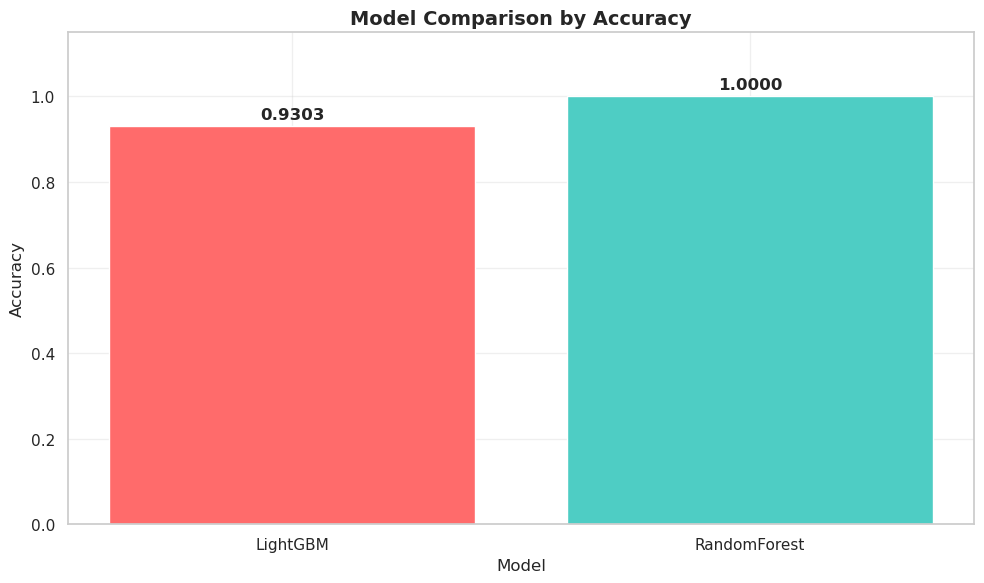

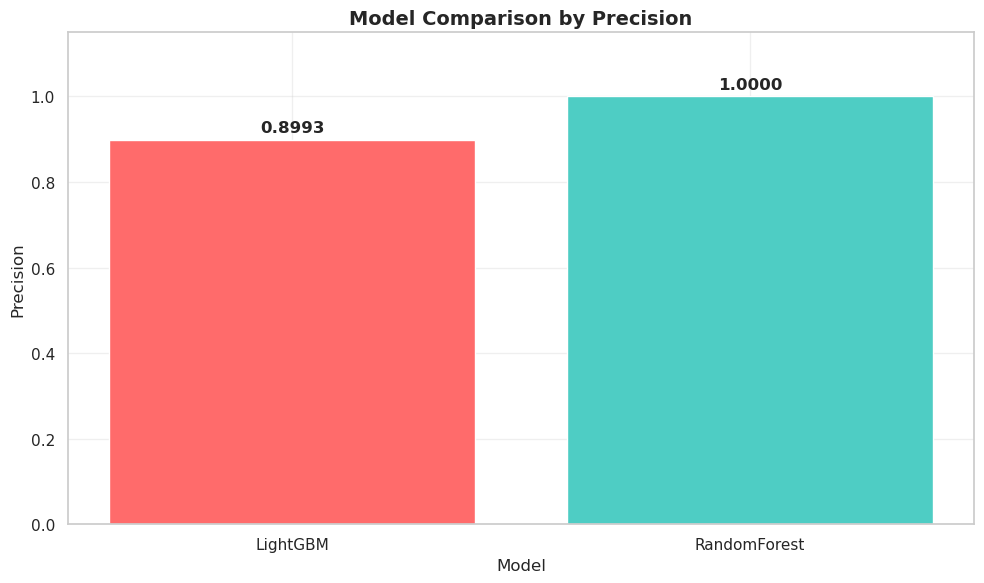

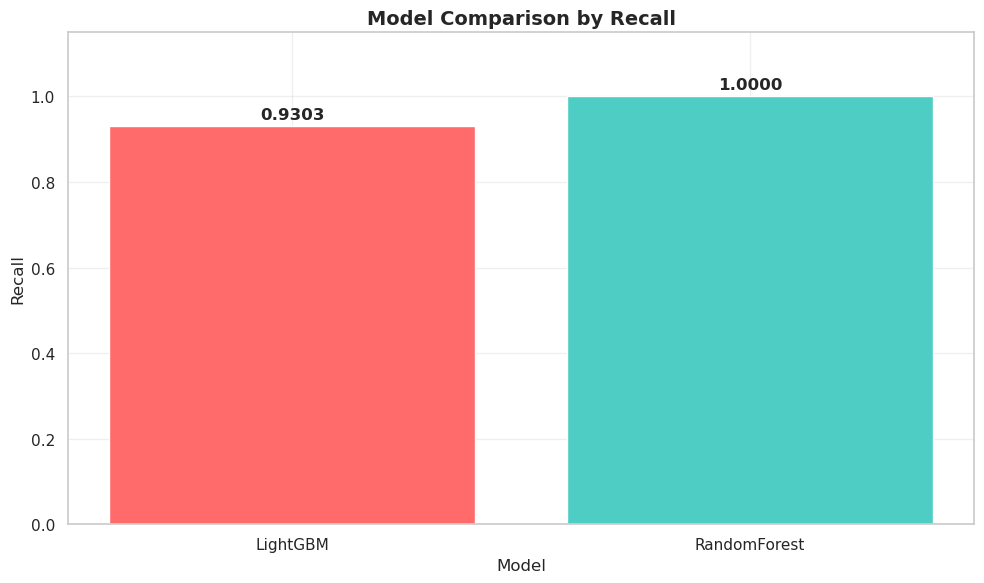

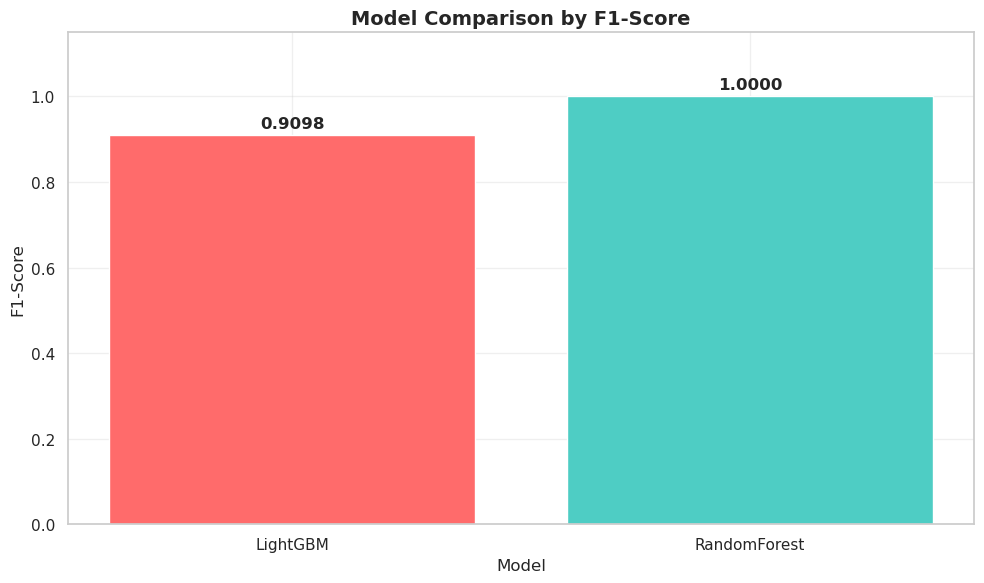

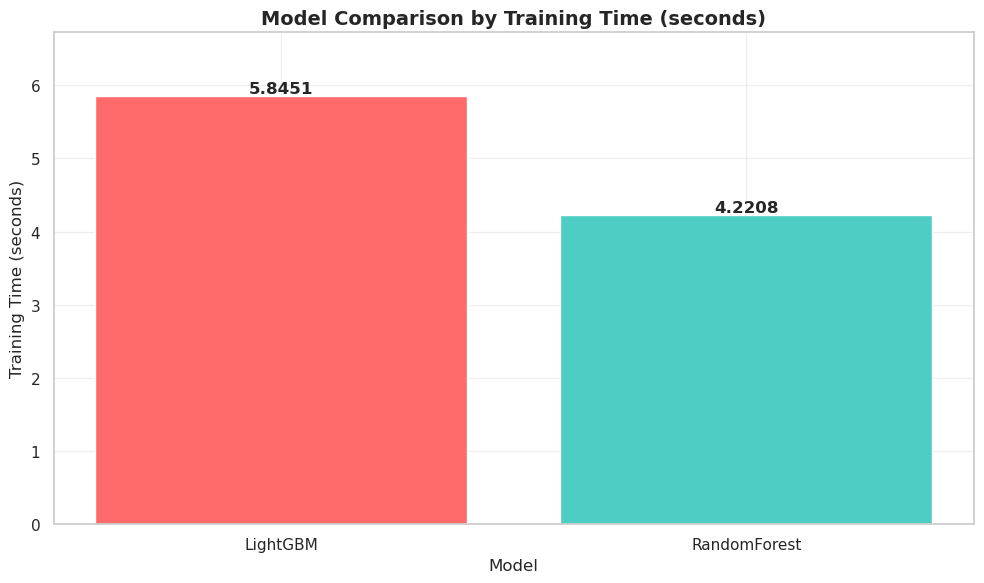

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_metrics(results, metric='accuracy'):
    """
    Plot model comparison for classification metrics
    """
    names = list(results.keys())
    
    # Map metric names to display names
    metric_display = {
        'accuracy': 'Accuracy',
        'precision': 'Precision', 
        'recall': 'Recall',
        'f1_score': 'F1-Score',
        'time': 'Training Time (seconds)'
    }
    
    # Get values for the requested metric
    values = [results[name][metric] for name in names]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(names, values, color=['#FF6B6B', '#4ECDC4'])
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.title(f'Model Comparison by {metric_display.get(metric, metric.upper())}', fontsize=14, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel(metric_display.get(metric, metric.upper()), fontsize=12)
    plt.ylim(0, max(values) * 1.15)  # Add some headroom for labels
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage with classification metrics:
print("📊 Plotting Model Comparison Charts...")

plot_model_metrics(results, metric='accuracy')
plot_model_metrics(results, metric='precision')
plot_model_metrics(results, metric='recall')
plot_model_metrics(results, metric='f1_score')
plot_model_metrics(results, metric='time')

In [58]:
import yaml
import os

# Display information about the best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
best_params = best_model.get_params()
best_accuracy = float(results[best_model_name]['accuracy'])
best_precision = float(results[best_model_name]['precision'])
best_recall = float(results[best_model_name]['recall'])
best_f1 = float(results[best_model_name]['f1_score'])
best_time = float(results[best_model_name]['time'])

print(f"🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f}")
print(f"   Precision: {best_precision:.4f}")
print(f"   Recall: {best_recall:.4f}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Training Time: {best_time:.2f} seconds")

# Get feature importance if available
feature_importance = {}
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🔍 Top 5 Most Important Features:")
    for i, row in importance_df.head(5).iterrows():
        print(f"   {row['feature']}: {row['importance']:.4f}")
        feature_importance[row['feature']] = float(row['importance'])

# Create model configuration
model_config = {
    'model': {
        'name': 'disease_classification_model',
        'best_model': best_model_name,
        'model_type': 'classification',
        'parameters': str(best_params),  # Convert to string for YAML compatibility
        'performance_metrics': {
            'accuracy': best_accuracy,
            'precision': best_precision,
            'recall': best_recall,
            'f1_score': best_f1,
            'training_time_seconds': best_time
        },
        'dataset_info': {
            'num_classes': len(np.unique(y_train_encoded)),
            'num_features': X_train.shape[1],
            'train_samples': X_train.shape[0],
            'test_samples': X_test.shape[0],
            'target_variable': 'prognosis'
        },
        'feature_importance': feature_importance,
        'label_encoder_classes': label_encoder.classes_.tolist() if 'label_encoder' in locals() else []
    }
}

# Save configuration
config_path = '../configs/model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    yaml.dump(model_config, f, default_flow_style=False)

print(f"\n✅ Saved model config to {config_path}")

# Also save as JSON for easier reading
import json
json_config_path = '../configs/model_config.json'
with open(json_config_path, 'w') as f:
    json.dump(model_config, f, indent=2)

print(f"✅ Saved model config (JSON) to {json_config_path}")

KeyError: 'model'